## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the corresponsing csv, store the dataset to the DB, preprocess it, and get it as a pytorch graph object

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    use_movies_fastRP=True,
)
# path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

Processing...


Encoding title...


Batches:   0%|          | 0/274 [00:00<?, ?it/s]

Encoding original_title...


Batches:   0%|          | 0/274 [00:00<?, ?it/s]

Encoding overview...


Batches:   0%|          | 0/274 [00:00<?, ?it/s]

Encoding tagline...


Batches:   0%|          | 0/274 [00:00<?, ?it/s]

Encoding fastRP_embedding_genres_keywords...


Done!


#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model

In [5]:
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=5,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=4,
    hidden_channels=64,
    out_channels=64
).to(device)
losses = train_test(
    model=model,
    epochs=500,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    logging_step=1,
)

c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Loss: 20.8683, Train: 3.2906, Val: 3.2813, Test: 3.3021
Epoch: 002, Loss: 16.7994, Train: 1.9331, Val: 1.9167, Test: 1.8885
Epoch: 003, Loss: 44.5726, Train: 2.9248, Val: 2.9117, Test: 2.9294
Epoch: 004, Loss: 13.3953, Train: 3.4246, Val: 3.4116, Test: 3.4313
Epoch: 005, Loss: 18.1640, Train: 3.4916, Val: 3.4777, Test: 3.4976
Epoch: 006, Loss: 18.8981, Train: 3.5014, Val: 3.4876, Test: 3.5079
Epoch: 007, Loss: 19.0149, Train: 3.4916, Val: 3.4777, Test: 3.4977
Epoch: 008, Loss: 18.9033, Train: 3.4711, Val: 3.4574, Test: 3.4775
Epoch: 009, Loss: 18.6814, Train: 3.4431, Val: 3.4294, Test: 3.4495
Epoch: 010, Loss: 18.3787, Train: 3.4017, Val: 3.3879, Test: 3.4079
Epoch: 011, Loss: 17.9419, Train: 3.3407, Val: 3.3284, Test: 3.3475
Epoch: 012, Loss: 17.2949, Train: 3.2487, Val: 3.2362, Test: 3.2542
Epoch: 013, Loss: 16.3608, Train: 3.1028, Val: 3.0916, Test: 3.1102
Epoch: 014, Loss: 14.9566, Train: 2.8664, Val: 2.8558, Test: 2.8714
Epoch: 015, Loss: 12.9158, Train: 2.4674, Val: 2

KeyboardInterrupt: 

#### Visualize

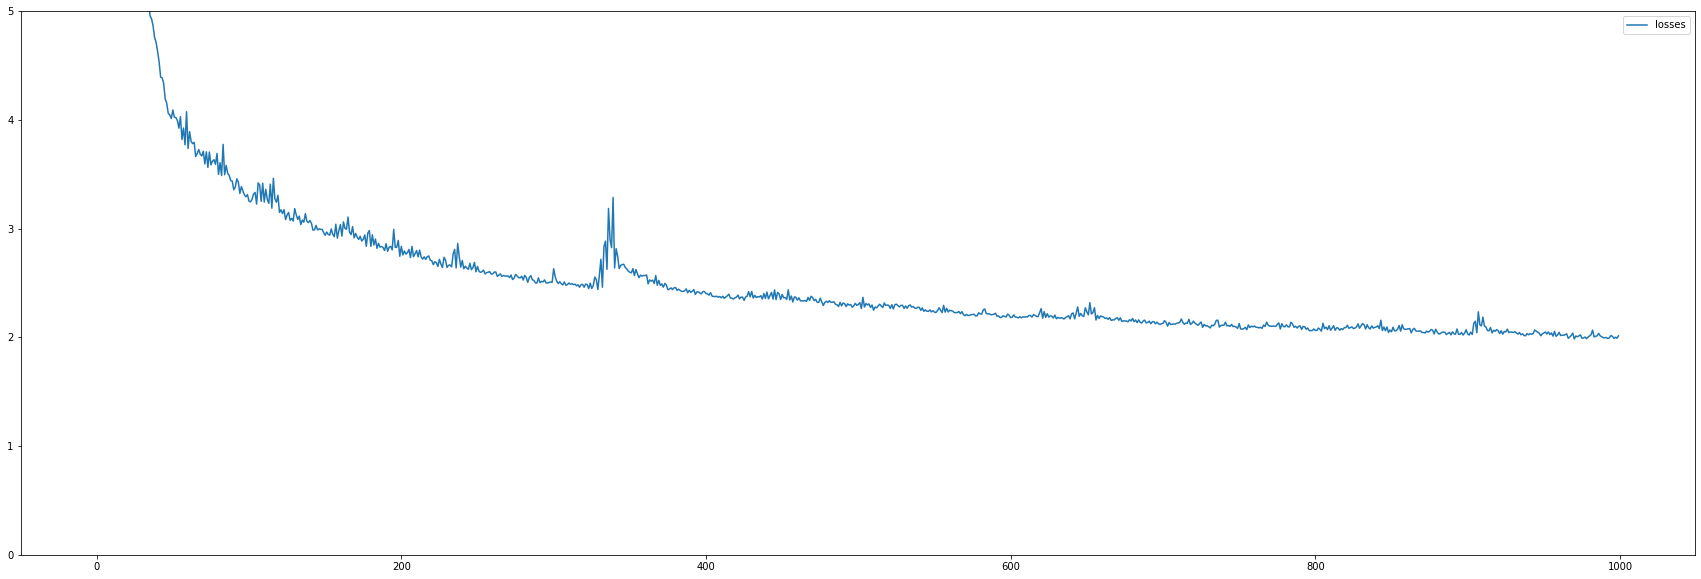

In [10]:
plot_loss({ "losses": losses }, ylim=5)